# Всероссийская олимпиада по искусственному интеллекту 2025

## Учебный бейзлайн-ноутбук № 2

### Введение

Приветствуем вас во втором ноутбуке нашей учебной серии!

В первой части мы уже успели разобрать основы машинного обучения: типы задач, метрики, сплиты, базовые инструменты - теперь здесь мы сосредоточимся на задаче **компьютерного зрения** (Computer Vision, CV).

Наша цель - научить модель смотреть на фотографии и делать на их основе выводы. Вместо того чтобы анализировать описания, мы будем анализировать пиксели. По условием задания у нас - `регрессии`, предсказываем числовое значение и строим модель, которая оценивает стоимость автомобиля по его фотографиям.

**План нашей работы**
Чтобы вам было проще ориентироваться, вот структура нашего ноутбука:

1. **Цифровое изображение и его преобразования.** Разберемся, как компьютер "видит" картинку (пиксели, каналы, тензоры). Поговорим о двух ключевых типах преобразований: `предобработке` (обязательные шаги, как изменение размера) и `аугментациях` (случайные изменения для усиления модели).

2. **Модели для компьютерного зрения.** Познакомимся с главной идеей современного CV: использованием предобученных моделей (например, `ResNet`). Узнаем, как взять мощную нейросеть, обученную на миллионах изображений, и быстро настроить ее под нашу конкретную задачу.

3. **Подходы, как подружить картинки и таблицы.** В нашей задаче есть не только фото, но и много полезной информации в таблице (пробег, тип кузова, комплектация). Мы обсудим основные стратегии "фьюжна" (`fusion`) - объединения данных из разных источников, чтобы получить максимально точное предсказание.

4. **Бейзлайн решения.** Соберем все полученные знания вместе и напишем базовое, но полноценное решение. Для начала оно будет предсказывать цену только по фотографиям, чтобы отточить навыки работы с CV-моделями.

5. **Заключение.** Подведем итоги и наметим четкий план по улучшению нашего бейзлайна. Главным шагом, конечно же, будет добавление табличных данных к нашей модели.

Отлично, тогда приступим - и первым делом обсудим цифровые изображения.


### Цифровое изображение и его преобразования

Когда мы говорим "картинка для нейросети", речь просто о таблице чисел. Представьте тетрадный лист в клетку: каждая клетка - `пиксель`. У цветной фотографии у каждого пикселя три базовых цвета: **R** (красный), **G** (зелёный), **B** (синий). Поэтому изображение - это тензор формата **H×W×C** (высота × ширина × каналы).

Компьютер хранит цвета как числа от 0 до 255 (тип `uint8`). Перед подачей в модель мы обычно переводим их в вещественные числа (`float32`) и нормируем.

В `PyTorch` модели ждут порядок каналов **C×H×W**. А в нашем датасете бывает по 1–4 фото на машину, поэтому в памяти это выглядит так:

* одно фото: `3 × 192 × 192`
* несколько фото на один объект: `N × 3 × 192 × 192`
* батч из `B` объектов: `B × N × 3 × 192 × 192`

> Забежим сразу вперед. В бейзлайне мы сделаем просто: прогоняем каждое фото через сеть и усредняем признаки (или предсказания) по фото - такой "[пулинг](https://deepmachinelearning.ru/docs/Neural-networks/ConvPool-1D/Pooling-1D) по картинкам" устойчив и быстрый.

**Предобработка vs Аугментации**

Фотографии из нашего датасета очень разные: одни квадратные, другие прямоугольные; одни большие, другие маленькие. Нейросеть, как заводской конвейер, может работать только с деталями одинакового размера. Поэтому, прежде чем подавать картинки в модель, их нужно привести к единому стандарту. Этот процесс делится на два типа преобразований.

> Но перед тем, как мы их рассмотрим, сразу отметим, шаги предобработки зависят от модели и метода, с которыми вы будете работать. Мы возьмем предобученный `ResNet18` (ImageNet), сверточную сеть, отрежем ей "голову" (ууу, кровожадные), добавим линейную голову на 1 число и научим предсказывать логарифм цены.

**1) Предобработка (Preprocessing)**

Это детерминированные (то есть одинаковые для всех) шаги, которые мы обязаны сделать, чтобы модель в принципе смогла работать с данными.

* **Размеры и пропорции.** Модели ждут на вход тензор фиксированного размера (например, `224×224`). Чтобы привести к нему разные картинки, есть несколько путей:
    * **Растянуть/сжать.** Самый простой, но плохой способ. Он искажает пропорции, и квадратный внедорожник может превратиться в вытянутый лимузин, что запутает модель.
    * **Обрезать края (`CenterCrop`).** Можно привести картинку к нужному размеру по меньшей стороне, а лишнее по большей - обрезать. Метод хороший, но есть риск отрезать важную деталь, например, бампер или спойлер.
    * **Сохранить пропорции и дополнить полями (`PadIfNeeded`).** Лучший компромисс. Мы уменьшаем картинку по длинной стороне до нужного размера, а пустое пространство по короткой стороне заполняем "полями" (обычно черными). Так мы сохраняем всю информацию и не искажаем объект. Именно этот метод используется в нашем бейзлайне.

* **Нормализация.** Значения пикселей от 0 до 255 - слишком большой разброс для нейросети. Мы приводим их к стандартному, маленькому диапазону. Для моделей, предобученных на гигантском датасете **ImageNet** (а это почти все современные модели), принято использовать конкретные "волшебные" числа:

  * mean = (0.485, 0.456, 0.406)
  * std  = (0.229, 0.224, 0.225)
  
  Это стабилизирует обучение, так как "распределение" наших данных становится похожим на то, на чём сеть училась изначально.

**2) Аугментации (Augmentations)**

Это случайные изменения, которые применяются *только к обучающим данным*. Их цель - сделать модель умнее, сильнее и устойчивее к разнообразию реального мира.

Аугментации можно разделить на несколько семейств:

* **Геометрические.** Имитируют съемку с разных ракурсов. Это отражения (`flip`), повороты (`rotate`), сдвиги и масштабирование (`shift/scale`, `affine`, `perspective`).
* **Фотометрические (цветовые).** Имитируют разные условия освещения и настройки камеры. Это изменение яркости/контраста, цветового тона, добавление шума или размытия (`brightness/contrast`, `hue/saturation`, `blur`, `noise`, `JPEG-компрессия`).
* **Маскирующие.** Имитируют частичное перекрытие объекта. Самый известный пример - `Cutout`, который случайно "вырезает" и закрашивает черным один или несколько квадратов на картинке. Это заставляет модель обращать внимание не на одну деталь, а на весь объект целиком.

Есть и более продвинутые техники вроде **MixUp/CutMix**, где смешиваются целые картинки и их таргеты, но в бейзлайне мы их использовать не будем.

```
Как это реализовано у нас?

Мы используем Albumentations: это быстрые и удобные трансформации на базе OpenCV.
В коде вы уже видели два пайплайна:

`train_tfms`: `LongestMaxSize → PadIfNeeded → Flip/Color/Rotate → Normalize → ToTensorV2`
`valid_tfms`: `LongestMaxSize → PadIfNeeded → Normalize → ToTensorV2`

```

> *Вы резонно спросите, а если картинок несколько?*

В нашей задаче на один автомобиль может быть до 4 фотографий. Есть несколько вариантов, как использовать их все:

* **Пулинг по эмбеддингам (`Mid-level fusion`).** Пропустить каждую картинку через нейросеть, получить для каждой вектор признаков (эмбеддинг), а затем эти векторы "схлопнуть" в один - например, усреднить (`mean-pooling`) или взять максимум по каждому измерению (`max-pooling`).
* **Пулинг по предсказаниям (`Late fusion`).** Получить предсказание цены для каждой картинки отдельно, а затем усреднить итоговые цены.

В нашем бейзлайне для простоты мы будем использовать только одно фото на автомобиль, но задействовать все - очевидный шаг к улучшению модели.

**И опять о них - о ресурсах**

Напоследок, пара практических советов:
* **Баланс.** Чем больше разрешение картинки (`IMG_SIZE`) и чем больше картинок в батче (`BATCH_SIZE`), тем больше видеопамяти (VRAM) на GPU вам потребуется. Если вы ловите ошибку `CUDA Out of Memory` (OOM), первое, что нужно сделать - уменьшить размер батча.
* **Ускорение.** На современных видеокартах можно использовать AMP (Automatic Mixed Precision), мы уже говорили о нем в прошлом ноутбуке. Это специальный режим вычислений в "полуточной" точности (`fp16`), который значительно ускоряет обучение и снижает потребление памяти почти без потери качества. В нашем коде он включается флагом `fp16=True`.

С обработкой разобрались, давайте посмотрим на модельки и подходы, которые мы можем использовать в задачах CV.

### Модели для компьютерного зрения

Итак, у нас есть картинки, представленные в виде чисел (тензоров). Казалось бы, можно создать нейросеть с нуля, которая будет смотреть на эти числа и предсказывать цену. Но есть одна проблема: это невероятно *сложно*, *долго* и *дорого*.

Так и не надо :)

В современном CV доминирует идея **трансферного обучения** (Transfer Learning).

> Суть проста. Мы берем модель, которую уже обучили на гигантском датасете (обычно это `ImageNet` с миллионами картинок и тысячей классов), и адаптируем ее под нашу узкую задачу. Мы не учим модель видеть с нуля, а как бы говорим уже опытному эксперту по картинкам: "Смотри, ты уже умеешь отличать кошек от собак и самолетов. Теперь используй свои знания, чтобы научиться отличать дорогие машины от дешевых".

Как мы это сделаем в бейзлайне?

1. Возьмем готовый *бэкбон* ("спину") - сеть, которая превращает картинку в вектор признаков (эмбеддинг);

2. Добавим "голову" под нашу задачу (у нас - регрессия цены → один выход);

3. Немного дообучаем (это называется `fine-tune`) и получим рабочую модель.

Это резко сокращает время, требования к данным и даёт хороший старт.

**Опять этот зоопарк**

Существует множество архитектур нейросетей для зрения. Вот основные типы, с которыми вы столкнетесь:

* **Сверточные нейронные сети** (CNN). Это классика CV. Такие сети работают по принципу "скользящего окошка": они смотрят на небольшие участки изображения, находят там простые паттерны (линии, углы), затем объединяют их в более сложные (текстуры, формы) и так далее, пока не "поймут" все изображение целиком.

    * `ResNet-18/34/50` - классика, надёжно, быстро, куча примеров. Отличный бэйзлайн.
    * `EfficientNet-B0/B3` - точнее при тех же FLOPs, но чувствительны к размеру входа и аугментациям.
    * `MobileNet/RegNet` - компактные, хороши на слабом GPU/CPU.
    * `ConvNeXt-T/S` - современные сверточные трансформеры: часто сильнее ResNet при умеренной цене.

* **Вижен-трансформеры**. Это более современный подход, пришедший из мира текстов. Вместо того чтобы смотреть на картинку по частям, трансформер разрезает ее на сетку из небольших патчей (как на слова в предложении) и анализирует их все сразу, находя взаимосвязи между самыми дальними частями изображения.

    * ViT/DeiT/Swin - трансформеры для изображений. Сильные, но обычно требуют чуть больше заботы (аугментации/размеры).

* **Мультимодальные модели**. Это супер-звезды последних лет. Их обучали одновременно и на картинках, и на текстах, которые эти картинки описывают. В итоге они научились понимать смысл изображения на очень глубоком уровне. Они могут связать фото собаки и текст "веселый золотистый ретривер бежит по траве".

    * CLIP/SigLIP - учились сопоставлять изображения и подписи. Их image-tower даёт очень универсальные эмбеддинги.

> Ну очень сильно советуем на досуге заглянуть на курсы (например, [Глубинное обучение-1](https://github.com/xiyori/intro-to-dl-hse)) и почитать/послушать про модели в глубинном обучении. Как обычно: просто не будет, но раз вы уже здесь, то к этому уже готовы.


**Два пути**

Итак, мы выбрали предобученную модель. Как именно ее использовать? Здесь, как и в задаче с текстами, есть два основных пути.

**Вариант 1: Fine-tuning**

Это тот самый подход, который мы используем в нашем бейзлайне. Мы берем предобученную модель (наш `ResNet18`) и видим в ней две части:

- "Спину" (`backbone`). Огромная часть сети, которая уже умеет извлекать из картинки полезные признаки (эмбеддинги). Это ее глаза и зрительная кора.

- "Голову" (`head`). Маленький последний слой, который принимал решение о том, к какому из 1000 классов `ImageNet` относится картинка.

Мы "отрезаем" старую голову (ува-ха-ха) и на ее место прикрепляем новую, которая подходит для нашей задачи - простой линейный слой, выдающий одно число (цену). После этого мы запускаем процесс дообучения (`fine-tuning`): показываем модели наши картинки с машинами и их ценами и немного корректируем веса всей сети, чтобы она "переквалифицировалась" с общей задачи на нашу, конкретную.

**Вариант 2: Feature Extraction**

Иногда нам не нужно, чтобы модель сама давала финальный ответ. Мы можем использовать ее только как очень умного "извлекателя признаков". Этот подход идеально подходит, когда у нас, помимо картинок, есть еще и табличные данные.

Схема такая:

1. **Получаем эмбеддинги**. Прогоняем все наши картинки через мощную модель (особенно хорошо здесь подходят мультимодальные, вроде CLIP или SigLIP) и на выходе получаем для каждой картинки один вектор чисел (эмбеддинг). Этот вектор - концентрированная суть изображения.

2. **Объединяем данные**. Добавляем этот вектор как новые колонки в нашу исходную таблицу с данными (пробег, цвет, тип кузова...).

3. **Обучаем решателя**. Обучаем на этой новой, обогащенной таблице классическую, но очень мощную модель, например, градиентный бустинг (CatBoost, LightGBM).

Этот двухэтапный подход невероятно силен. Нейросеть выступает в роли "эксперта-консультанта" по картинкам, а бустинг - в роли "суперменеджера", который принимает финальное решение, учитывая и мнение эксперта по фото, и все остальные табличные данные.

### Как объединять изображения и табличные признаки

Наш бейзлайн, вы скоро уже до него доберетесь, работающий только с картинками, - это отличная отправная точка. Но давайте будем честны: по одной лишь фотографии сложно отличить машину с пробегом 10 000 км от такой же, но с пробегом 150 000 км. Вся эта бесценная информация лежит в табличных данных.

Задача специалиста по данным - использовать все доступные источники информации. Процесс объединения данных из разных источников (в нашем случае, картинок и таблиц) называется **фьюжном **(`fusion`). Существует три базовых подхода.

**Подход 1: Late Fusion (Ансамбль на уровне предсказаний)**

Это самый простой и интуитивный способ. Его можно назвать "советом экспертов".

Как это работает:

1.  Обучаем CV-модель (например, наш `ResNet`), которая смотрит только на фото и выдает свое предсказание цены ($\hat y_{\text{image}}$).
2.  Затем берем только табличные данные и обучаем на них отдельную, классическую модель. Этот "эксперт" тоже выдает свое предсказание цены ($\hat y_{\text{tabular}}$).
3.  А после просто смешиваем их предсказания, например, взяв взвешенное среднее:

    $$
    \hat y = w \cdot \hat y_{\text{image}} + (1-w)\cdot \hat y_{\text{tabular}}
    $$

Где весовой коэффициент `w` (например, 0.4) можно подобрать на валидационной выборке, чтобы минимизировать нашу метрику `medianAPE`.

**Плюсы.** Просто, надёжно, легко реализовать.

**Минусы.** Модели не "общаются" друг с другом во время обучения.

**Подход 2: Mid-level Fusion (Склеиваем признаки)**

Это более продвинутый и, как правило, более мощный подход.

1. Прогоняем все картинки через `ResNet`, но вместо предсказания цены забираем *эмбеддинг*, который нейросеть извлекла из изображения (в нашем случае, это 512 чисел).
2. Все табличные признаки тоже превращаем в числа (нормализуем пробег, кодируем категории и т.д.).
3. Соединяем вектор от картинки и вектор от таблицы в один огромный вектор признаков.
4. Обучаем одну мощную модель на этом объединенном сете.

**Плюсы.** Модель видит всю информацию сразу и может находить сложные зависимости (например, "для *такого-то* типа кузова на фото низкий пробег из таблицы особенно сильно повышает цену").

**Минусы.** Нужно аккуратно готовить все признаки и следить за утечками данных.

**Подход 3: Early Fusion (Продвинутый)**

В этом подходе мы строим единую, сложную нейросеть, у которой есть несколько "входов": одна "голова" для картинок, другая - для табличных данных. Признаки из них объединяются где-то в середине архитектуры. Это мощно, но сложно в реализации и не подходит для бейзлайна.

> Пара советов перед стартом:
>
> Помните, что данные разделены по времени (тест - это декабрь). Для честной оценки всегда делайте валидацию на "конце" обучающих данных (например, на ноябре). Все "обучаемые" преобразования (скейлеры, кодировщики) настраивайте (`.fit()`) **только на `train`**!
>
> Категориальные признаки можно превратить в `one-hot` векторы или просто оставить как есть и отдать в `CatBoost` (он умеет работать с категориями напрямую). А можно и в набор бинарных флагов.
>
> Попробуйте обучиться на логарифме `log1p(price)`, как в бейзлайне. Это приятно.


## Бейзлайн

Ну что ж, теория - это хорошо, но пора переходить к практике! Сейчас мы соберем наше первое, базовое решение для задачи предсказания цены.

Наша стратегия для бейзлайна:

1. **Фокусируемся на картинках.** Мы намеренно будем использовать только фотографии автомобилей, чтобы отточить навыки работы с CV-моделями. Подключение табличных данных - это следующий, очевидный шаг для улучшения, который мы оставим уже за вами.

2. **Берем готовую модель.** Мы не будем изобретать нейросеть с нуля. Мы возьмем популярную и проверенную архитектуру `ResNet18`, уже предобученную на миллионах изображений из *ImageNet*.

3. **Просто и понятно.** Весь код будет написан максимально прямолинейно, чтобы был понятен каждый этап: от загрузки данных до получения файла с предсказаниями.

Тогда поехали.



### Подготовка окружения и импорты

In [ ]:
import os
import random
import cv2 # OpenCV для работы с изображениями
import re
import requests

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import resnet18, ResNet18_Weights # Наша предобученная модель

from collections import defaultdict # Удобный словарь, который не выдает ошибку, если ключа нет
import matplotlib.pyplot as plt

In [ ]:
# Рекомендуем запускать код в среде выполения с cuda

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


### Загрузка данных

Фотографии для соревнования хранятся в облаке. Нам нужно написать несколько вспомогательных функций, чтобы скачать и распаковать архивы с изображениями. Не стоит скачивать их к себе на рабочую машину, если вы работаете в облачных сервисах - только потратите время.

In [ ]:
def get_direct_file_link(mailru_file_url: str) -> str:
    """
    Превращает ссылку на конкретный файл внутри папки cloud.mail.ru/public/XXX/YYYY/filename
    в прямую ссылку на CDN.
    """
    resp = requests.get(mailru_file_url)
    if resp.status_code != 200:
        raise RuntimeError(f"Ошибка {resp.status_code} при запросе {mailru_file_url}")
    page = resp.text

    match = re.search(r'dispatcher.*?weblink_get.*?url":"(.*?)"', page)
    if not match:
        raise RuntimeError("Не удалось найти CDN ссылку в HTML")
    base_url = match.group(1)

    # вычленяем /XXX/YYYY/filename
    parts = mailru_file_url.split('/')[-3:]
    return f"{base_url}/{parts[0]}/{parts[1]}/{parts[2]}"

def download_from_mailru(file_url: str, local_name: str):
    direct = get_direct_file_link(file_url)
    print(f"Скачиваем {file_url} → {local_name}")
    os.system(f"wget --content-disposition '{direct}' -O '{local_name}'")

In [ ]:
# Ссылки на архивы с картинками
train_link = "https://cloud.mail.ru/public/2kaD/W4xWY9vgr/train_images.zip"
test_link  = "https://cloud.mail.ru/public/2kaD/W4xWY9vgr/test_images.zip"

train_zip = download_from_mailru(train_link, "train_images.zip")
test_zip  = download_from_mailru(test_link,  "test_images.zip")

Скачиваем https://cloud.mail.ru/public/2kaD/W4xWY9vgr/train_images.zip → train_images.zip
Скачиваем https://cloud.mail.ru/public/2kaD/W4xWY9vgr/test_images.zip → test_images.zip


In [ ]:
# Распаковываем архивы в соответствующие папки

!unzip -q train_images.zip -d train_images
!unzip -q test_images.zip -d test_images

### Константы и гиперпараметры

Хорошая практика - выносить все ключевые настройки в начало кода. Так их легко найти и изменить, проводя новые эксперименты.

In [ ]:
TRAIN_PQ = "train_dataset.parquet"
TEST_PQ  = "test_dataset.parquet"
TRAIN_IMG_DIR = "train_images"
TEST_IMG_DIR  = "test_images"

TRAIN_CSV = "train.csv"
TEST_CSV  = "test.csv"
CKPT_NAME = "efishnet4"
CKPT_PATH = f"{CKPT_NAME}.pth"
USE_LOG_TARGET = True # Используем логарифмический маштаб таргета

In [ ]:
# Гиперпараметры

IMG_SIZE = 288        # Приводим все картинки к размеру 192x192
N_IMAGES_PER_ITEM = 4  # Для бейзлайна берем только 1 картинку на объявление
BATCH_SIZE = 16        # Сколько картинок обрабатывать за один шаг
EPOCHS = 5             # Сколько раз прогонять все обучающие данные
LR = 3e-4              # Скорость обучения (learning rate)
WEIGHT_DECAY = 1e-6    # Параметр регуляризации для предотвращения переобучения
VAL_SIZE = 0.2         # Какую долю данных отложить для валидации (20%)
KEEP_RATIO = 1       # Для ускорения экспериментов можем взять не все данные, а только 50%

# Фиксируем "зерно" случайности, чтобы наши эксперименты были повторяемыми
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Подготовка данных

Сейчас у нас есть таблица с данными (`.parquet`) и папка с картинками. Нам нужно их подружить - для каждой строки в таблице найти соответствующий файл с изображением. Мы напишем функцию, которая создаст удобный `CSV-файл` с тремя колонками: ID объявления, путь к картинке и цена.

In [ ]:
# Загружаем табличные данные
train_df = pd.read_parquet(TRAIN_PQ)
test_df  = pd.read_parquet(TEST_PQ)

In [ ]:
train_df.head() # посмотрим на данные

,ID,equipment,body_type,drive_type,engine_type,doors_number,color,pts,audiosistema,diski,...,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult,price_TARGET
0,58146,Базовая,Седан,Передний,Бензин,4,Синий,Дубликат,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],51000
1,112144,Базовая,Универсал,Задний,Бензин,5,Бежевый,Оригинал,None,"14""",...,[None],[None],[None],[None],[None],[None],[Сигнализация],[None],[None],195000
2,120705,None,Внедорожник,Полный,Гибрид,5,Чёрный,Электронный,None,None,...,"[Противотуманные, Омыватели фар, Адаптивное ос...","[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Задних сидений, Зеркал, Зад...","[Сиденья водителя, Задних сидений, Зеркал, Рул...","[Фронтальная для водителя, Коленные, Шторки, Б...","[Автопарковщик, Датчик дождя, Датчик света, Па...","[Сигнализация, Центральный замок, Иммобилайзер...","[Кожаный руль, Люк]","[Управление на руле, Атермальное остекление]",7251000
3,291392,Titanium,Седан,Передний,Бензин,4,Серебряный,Оригинал,6 колонок,"16""",...,[None],"[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Заднего стекла]",[None],"[Фронтальная для водителя, Коленные, Шторки, Б...","[Датчик дождя, Датчик света, Парктроник задний...","[Сигнализация, Центральный замок]",[Кожаный руль],[Управление на руле],1067000
4,35742,Базовая,Седан,Передний,Бензин,4,Чёрный,Оригинал,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],54000


In [ ]:
def build_img_csv(df, img_dir, out_csv, n_images=1, keep_ratio=1.0, seed=42):

    """
    Функция для создания CSV-файла, связывающего ID объявления с путями к его фотографиям.
    """

    all_files = os.listdir(img_dir)
    id_to_files = defaultdict(list)
    for fname in all_files:
        if fname.endswith(".jpg"):
            iid = int(fname.split("_")[0])  # предполагаем формат ID_xxx.jpg
            id_to_files[iid].append(os.path.join(img_dir, fname))

    rows = []
    for r in df.itertuples(index=False):
        iid = getattr(r, "ID")
        paths = sorted(id_to_files.get(iid, []))
        if len(paths) > n_images:
            paths = paths[:n_images]

        row = {
            "item_id": iid,
            "paths": ";".join(paths)
        }

        # цена есть только в train
        if "price_TARGET" in df.columns:
            row["price"] = getattr(r, "price_TARGET")
        else:
            row["price"] = -1  # заглушка для test

        rows.append(row)

    # Создаем и сохраняем итоговый DataFrame
    csv_df = pd.DataFrame(rows)

    # Если нужно, оставляем только часть данных для быстрых экспериментов
    if keep_ratio < 1.0:
        csv_df = csv_df.sample(frac=keep_ratio, random_state=seed).reset_index(drop=True)

    csv_df.to_csv(out_csv, index=False)
    print(f"CSV сохранён: {out_csv}, shape={csv_df.shape}")
    return csv_df

In [ ]:
# Запускаем функцию для train и test выборок

train_csv_df = build_img_csv(train_df, TRAIN_IMG_DIR, TRAIN_CSV)
test_csv_df  = build_img_csv(test_df,  TEST_IMG_DIR,  TEST_CSV)

CSV сохранён: train.csv, shape=(70000, 3)
CSV сохранён: test.csv, shape=(25000, 3)


In [ ]:
train_csv_df.head()

,item_id,paths,price
0,58146,train_images/58146_0.jpg,51000
1,112144,train_images/112144_0.jpg,195000
2,120705,train_images/120705_0.jpg,7251000
3,291392,train_images/291392_0.jpg,1067000
4,35742,train_images/35742_0.jpg,54000


### Создание конвейера данных (`Dataset` и `DataLoader`)

Прежде чем обучать модель, нам нужно создать конвейер для подачи данных. Он состоит из двух частей, один из них вам уже знаком:

1. `Dataset`. Это чертеж одного объекта. Он знает, как по индексу (например, 5-й элемент) найти нужную строку в `CSV`, прочитать картинку с диска, применить к ней аугментации и вернуть готовый для обучения тензор изображения и его цену.

2. `DataLoader`. Это начальник смены на конвейере (мы тут все на заводе работаем, если что). Он берет `Dataset`, говорит ему, сколько объектов нужно взять за раз (`batch_size`), и эффективно собирает их в одну большую пачку (батч), готовую для отправки на GPU.

Сначала определим нашу функцию для расчета метрики `medianAPE` и опишем наши "инструменты" для преобразования изображений из библиотеки `Albumentations`.

In [ ]:
# Реализуем функцию для подсчета medianAPE в точности как в правилах соревнования

def median_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true > 0
    ape = np.abs(y_true[mask] - y_pred[mask]) / (y_true[mask] + 1e-6)
    return float(np.median(ape))

In [ ]:
# Создаем конвейер преобразований для ТРЕНИРОВОЧНЫХ данных

train_tfms = A.Compose([
    # Шаги предобработки (обязательные)
    A.LongestMaxSize(IMG_SIZE), # Уменьшаем картинку по длинной стороне до IMG_SIZE
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_CONSTANT), # Добавляем поля до квадрата
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Нормализуем "магическими" числами ImageNet

    # Шаги аугментации (случайные)
    A.HorizontalFlip(p=0.5), # Отражаем по горизонтали с вероятностью 50%
    A.RandomBrightnessContrast(p=0.3), # Меняем яркость и контраст
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10,
                       border_mode=cv2.BORDER_CONSTANT, p=0.5), # Сдвигаем, масштабируем и поворачиваем

    # Финальный шаг предобработки
    ToTensorV2(), # Превращаем numpy-массив в тензор PyTorch
])

# Создаем конвейер преобразований для ВАЛИДАЦИОННЫХ данных (только обязательные шаги)
valid_tfms = A.Compose([
    A.LongestMaxSize(IMG_SIZE),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Теперь напишем класс `CarsDataset`. Его главная задача - по одному `idx` (индексу) вернуть полностью готовую пару (тензор_картинки, цена).

In [ ]:
def _safe_imread(p: str, fallback_hw=(IMG_SIZE, IMG_SIZE)) -> np.ndarray:
    """Безопасно читает картинку. Если файл битый или не существует, возвращает черный квадрат."""
    img = cv2.imread(p, cv2.IMREAD_COLOR)
    if img is None:
        # Если картинка не прочиталась, создаем "пустышку"
        h, w = fallback_hw
        img = np.zeros((h, w, 3), dtype=np.uint8)
    else:
        # OpenCV читает картинки в формате BGR, а нам нужен RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


class CarsDataset(Dataset):
    """
    Класс датасета для PyTorch.
    """
    def __init__(self, df: pd.DataFrame, is_train: bool = True):
        self.df = df.reset_index(drop=True)
        # Выбираем нужный набор аугментаций в зависимости от того, обучающий это датасет или нет
        self.tfms = train_tfms if is_train else valid_tfms
        self.has_target = "price" in df.columns

    def __len__(self):
        """Возвращает общее количество объектов в датасете."""
        return len(self.df)

    def __getitem__(self, idx: int):
        """По индексу `idx` возвращает один готовый для обучения пример."""
        row = self.df.iloc[idx]
        # Берем пути к картинкам из строки и очищаем от возможных пустых значений
        paths = [p for p in str(row["paths"]).split(";") if p and p.lower() != "nan"][:N_IMAGES_PER_ITEM]

        imgs = []
        for p in paths:
            img = _safe_imread(p) # Читаем картинку
            img = self.tfms(image=img)["image"].contiguous() # Применяем аугментации
            imgs.append(img)

        # Если картинок меньше, чем N_IMAGES_PER_ITEM, добиваем "пустыми" тензорами
        while len(imgs) < N_IMAGES_PER_ITEM:
            imgs.append(torch.zeros(3, IMG_SIZE, IMG_SIZE))

        # Собираем список тензоров в один тензор формы (N, C, H, W)
        imgs = torch.stack(imgs, dim=0)

        # Если это обучающие данные, возвращаем картинки и цену
        if self.has_target:
            y = torch.tensor(row["price"], dtype=torch.float32)
            # Если включен флаг, берем логарифм от цены. Это стабилизирует обучение.
            if USE_LOG_TARGET:
                y = torch.log1p(y)
            return imgs, y
        # Если это тестовые данные, возвращаем картинки и ID объявления
        else:
            return imgs, torch.tensor(row.get("item_id", -1), dtype=torch.long)

### Сборка и обучение модели

Все подготовительные работы завершены. Теперь мы можем собрать нашу модель, определить цикл обучения и запустить процесс!

**Модель и `collate_fn`**

Мы возьмем предобученную `resnet18`, отрежем у нее последний слой, который был предназначен для классификации 1000 классов `ImageNet`, и прикрепим свою голову - простой линейный слой, который будет выдавать одно число (нашу предсказанную цену).

In [ ]:
def collate_fn(batch):
    """
    Вспомогательная функция для DataLoader. Она умеет правильно собирать
    пары (картинка, цена) или (картинка, ID) в один батч.
    """
    imgs = torch.stack([b[0] for b in batch], dim=0)  # (B, N, C, H, W)
    target = batch[0][1]

    # Если таргет - это число с плавающей точкой (цена), собираем тензор цен
    if torch.is_tensor(target) and target.dtype.is_floating_point:
        y = torch.stack([b[1] for b in batch], dim=0)  # (B,)
        return imgs, y
    # Иначе это ID, собираем тензор ID
    else:
        ids = torch.stack([b[1] for b in batch], dim=0)
        return imgs, ids
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

class ResNetRegressor(nn.Module):

    def __init__(self, dropout_rate=0.3, hidden_size=256):
        super().__init__()
        # Загружаем EfficientNet-B2 с весами, предобученными на ImageNet
        backbone = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

        # Получаем размер эмбеддинга для EfficientNet-B2 (1408)
        in_features = backbone.classifier[1].in_features

        # Удаляем классификатор и создаем backbone
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Добавляем адаптивный пулинг
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Сложная голова для регрессии
        self.head = nn.Sequential(
            # Первый скрытый слой
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            # Второй скрытый слой
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            # Третий скрытый слой
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),

            # Четвертый скрытый слой (дополнительный для большей сложности)
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.BatchNorm1d(hidden_size // 8),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 3),

            # Выходной слой
            nn.Linear(hidden_size // 8, 1)
        )

        # Инициализация весов головы
        self._initialize_weights()

    def _initialize_weights(self):
        """Инициализация весов головы"""
        for m in self.head.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x имеет форму (Batch, N_images, Channels, Height, Width)
        B, N, C, H, W = x.shape

        # "Распрямляем" батч, чтобы обработать все картинки одним прогоном
        x = x.view(B*N, C, H, W)

        # Получаем эмбеддинги (векторы признаков)
        feats = self.backbone(x)          # (B*N, 1408, H', W')
        feats = self.avgpool(feats)       # (B*N, 1408, 1, 1)
        feats = feats.view(B*N, -1)       # (B*N, 1408)

        # Возвращаем эмбеддингам форму, связанную с батчем
        feats = feats.view(B, N, -1)      # (B, N, 1408)

        # Усредняем эмбеддинги по всем картинкам одного объявления
        feats = feats.mean(dim=1)         # (B, 1408)

        # Прогоняем усредненный эмбеддинг через сложную "голову"
        out = self.head(feats)            # (B, 1)

        return out.squeeze(1)             # (B,) - возвращаем вектор предсказаний         # (B,) - возвращаем вектор предсказаний

**Цикл обучения**

Это сердце нашего кода. Функция `run_epoch` описывает логику одного полного прохода по данным (одной эпохи). Мы будем вызывать ее много раз - для обучения на `train` данных и для оценки на `validation` данных.

In [ ]:
def run_epoch(model, loader, optimizer=None, device="cuda"):
    """Прогоняет одну эпоху обучения или валидации."""
    is_train = optimizer is not None  # Если передан optimizer - это обучение
    model.train(is_train) # Переключаем модель в режим train или eval

    losses = []
    preds_log_all, y_log_all = [], []

    # tqdm оборачивает итератор, чтобы показывать красивую полоску прогресса
    pbar = tqdm(loader, desc="Train" if is_train else "Valid", leave=False)
    for imgs, y_log in pbar:
        # Переносим данные на GPU
        imgs = imgs.to(device, non_blocking=True)
        y_log = y_log.view(-1).to(device)

        # Получаем предсказания модели
        preds_log = model(imgs)
        # Считаем ошибку. L1Loss (MAE) хорошо работает для регрессии, особенно с логарифмом.
        loss = nn.L1Loss()(preds_log, y_log)

        if is_train:
            optimizer.zero_grad(set_to_none=True) # Обнуляем градиенты
            loss.backward()                       # Считаем градиенты
            optimizer.step()                      # Обновляем веса модели

        # Собираем статистику
        losses.append(loss.item())
        preds_log_all.append(preds_log.detach().cpu())
        y_log_all.append(y_log.detach().cpu())
        pbar.set_postfix({"loss": f"{loss.item():.3f}"}) # Показываем текущую ошибку в прогресс-баре

    # Считаем итоговые метрики за всю эпоху
    preds_log_all = torch.cat(preds_log_all).numpy()
    y_log_all     = torch.cat(y_log_all).numpy()

    # Если использовали логарифм, возвращаем предсказания и таргет в исходный масштаб
    preds  = np.expm1(preds_log_all)
    y_true = np.expm1(y_log_all)

    medape = median_absolute_percentage_error(y_true, preds) * 100.0
    return float(medape), float(np.mean(losses))

**Запускаем нашу пушку!**

In [ ]:
history = {
    "epoch": [],
    "tr_loss": [],
    "tr_medape": [],
    "val_loss": [],
    "val_medape": [],
}

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"Память после очистки: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

Память после очистки: 0.33 GB


In [ ]:
df = pd.read_csv(TRAIN_CSV)
trn_df, val_df = train_test_split(df, test_size=VAL_SIZE, random_state=SEED, shuffle=True)

train_ds = CarsDataset(trn_df, is_train=True)
valid_ds = CarsDataset(val_df, is_train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          pin_memory=True, num_workers=4, drop_last=True,
                          collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          pin_memory=True, num_workers=4, drop_last=False,
                          collate_fn=collate_fn)

model = ResNetRegressor().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

best_val_medape = float("inf")

# Главный цикл обучения
for epoch in range(1, EPOCHS + 1):
    print(f"\nЭпоха {epoch}/{EPOCHS}")
    # Запускаем эпоху обучения
    tr_medape, tr_loss = run_epoch(model, train_loader, optimizer, device=device)
    # Запускаем эпоху валидации (optimizer=None)
    val_medape, val_loss = run_epoch(model, valid_loader, optimizer=None, device=device)

    print(f"Train loss: {tr_loss:.3f} | medianAPE: {tr_medape:.2f}%")
    print(f"Valid loss: {val_loss:.3f} | medianAPE: {val_medape:.2f}%")

    # Сохраняем историю
    history["epoch"].append(epoch)
    history["tr_loss"].append(tr_loss)
    history["tr_medape"].append(tr_medape)
    history["val_loss"].append(val_loss)
    history["val_medape"].append(val_medape)

    # Сохраняем модель (чекпоинт), только если она показала лучший результат на валидации
    if val_medape < best_val_medape:
        best_val_medape = val_medape
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "val_medape": val_medape
        }, CKPT_PATH)
        print(f"✓ Модель сохранена в эпоху {epoch} -> {CKPT_PATH}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Эпоха 1/5


OutOfMemoryError: CUDA out of memory. Tried to allocate 162.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 102.12 MiB is free. Process 8183 has 14.63 GiB memory in use. Of the allocated memory 14.05 GiB is allocated by PyTorch, and 462.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
 print(f"Train loss: {tr_loss:.3f} | medianAPE: {tr_medape:.2f}%")

Train loss: 2.898 | medianAPE: 96.77%


### Анализ результатов и инференс на тесте

Обучение завершено! Давайте посмотрим на графики, чтобы понять, как вела себя модель, а затем используем лучшую сохраненную версию для предсказаний на тестовых данных.

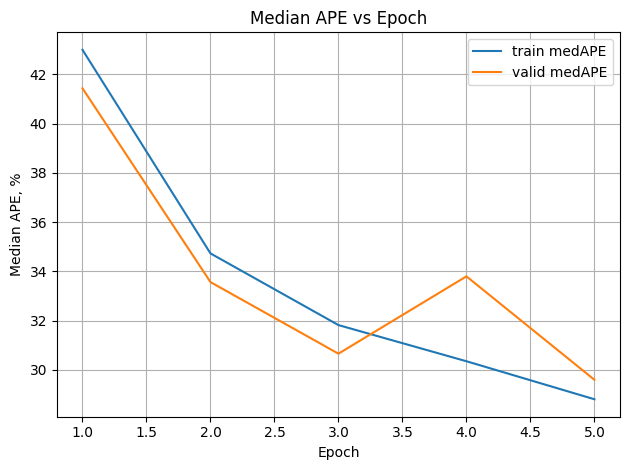

In [ ]:
# Визуализация истории обучения

plt.figure()
plt.plot(history["epoch"], history["tr_medape"], label="train medAPE")
plt.plot(history["epoch"], history["val_medape"], label="valid medAPE")
plt.xlabel("Epoch")
plt.ylabel("Median APE, %")
plt.title("Median APE vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"medape_vs_epoch_{CKPT_NAME}.png", dpi=150)
plt.show()


In [ ]:
# Сохраняем историю в CSV для дальнейшего анализа

csv_name = f"{CKPT_NAME}.csv"
df_hist = pd.DataFrame(history)
df_hist.to_csv(csv_name, index=False)

In [ ]:
# Инференс на тестовых данных

test_df = pd.read_csv(TEST_CSV)
test_ds = CarsDataset(test_df, is_train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=8, pin_memory=True, drop_last=False,
                         collate_fn=collate_fn)

# Загружаем лучшую сохраненную модель
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval() # Переводим модель в режим предсказания

preds_all, ids_all = [], []
# torch.no_grad() отключает расчет градиентов, что ускоряет инференс и экономит память
with torch.no_grad():
    for imgs, ids in tqdm(test_loader, desc="Test", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        preds = model(imgs) # Получаем предсказания в лог-масштабе

        # Если нужно, возвращаем в исходный масштаб
        if USE_LOG_TARGET:
            preds = torch.expm1(preds)

        preds_all.append(preds.cpu())
        ids_all.append(ids.cpu())

# Собираем все предсказания и ID в единые массивы
preds_all = torch.cat(preds_all).squeeze().numpy()
ids_all   = torch.cat(ids_all).squeeze().numpy()

# Формирование файла для сабмита
submission_df = pd.DataFrame({
    "ID": ids_all,
    "price_TARGET": preds_all
})

submission_df.to_csv("submission.csv", index=False)
submission_df.head()

In [ ]:
# Убедимся, что наш файл имеет ту же структуру и размер, что и образец
# Это простой, но очень полезный санити-чек

sample = pd.read_csv("sample_submission.csv")
assert list(submission_df.columns) == ["ID", "target"]
assert len(submission_df) == len(sample)

print("Размер сабмита:", submission_df.shape)

Воу, ну неплохо - ваша CV-моделька зафайнтюнена. Наши поздравления! ✌

Куда теперь можно прыгнуть? Вот несколько вариантов:

1.  Подружить" картинки и таблицы (Fusion). Очевидный шаг. Ваша модель по картинке уже умеет генерировать эмбеддинг (вектор признаков). Возьмите этот вектор и "склейте" его с признаками из таблицы (`пробег`, `тип кузова`, `цвет` и т.д.), а затем обучите на этой объединенной таблице мощный градиентный бустинг.
2.  Больше картинок - больше информации. Разумно не ограничиваем себя.
3.  Более мощный старт. Мы использовали легкий `ResNet18`. Попробуйте более современные и мощные архитектуры.
4.  Тонкая настройка. Не бойтесь экспериментировать с гиперпараметрами: размером картинки (`IMG_SIZE`), скоростью обучения (`LR`), количеством эпох и, конечно же, набором аугментаций.

Машинное обучение - это итеративный процесс. Пробуйте новые идеи, измеряйте результат на валидационной выборке и оставляйте те изменения, которые действительно улучшают вашу метрику.

## Заключение

Мы вместе прошли неплохой путь от знакомства с цифровой душой фотографии до создания полноценного нейросетевого решения, которое умеет видеть и оценивать автомобили.

Что мы сделали в этом ноутбуке:

- **Научились говорить на языке CV.** Разобрались, что такое тензор изображения, зачем нужны предобработка и аугментации, и как они реализованы в библиотеке `Albumentations`.
- **Освоили Transfer Learning.** Поняли, как взять мощную, предобученную на миллионах картинок модель (`ResNet18`), и быстро адаптировать ее для нашей задачи регрессии.
- **Построили CV-пайплайн.** Собрали полный конвейер от чтения "сырых" картинок до обучения модели и генерации файла с предсказаниями.

Наш бейзлайн, основанный только на картинках, - это отличная и очень важная отправная точка. Но настоящая магия в этой задаче начнется тогда, когда мы научим модель видеть не только изображение, но и всю доступную информацию о машине.

Удачи в экспериментах!